# Data Preprocessing

In [1]:
from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import superglue
import seaborn as sns
from matplotlib import rcParams

In [3]:
superglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [4]:
data_path = "/gpfs/gibbs/pi/zhao/tl688/"

In [5]:
import scanpy as sc
adata_atac = sc.read_h5ad(f'{data_path}/10x-Multiome-Pbmc10k-ATAC.h5ad')
# adata_atac.X = adata_atac.X.toarray()
adata_atac.obs['label'] = list(adata_atac.obs['cell_type'])
adata_gex  = sc.read_h5ad(f'{data_path}/10x-Multiome-Pbmc10k-RNA.h5ad')
# adata_gex.X = adata_gex.X.toarray()
adata_gex.obs['label'] = list(adata_gex.obs['cell_type'])


In [6]:
adata_gex.var_names_make_unique()

In [7]:
# ###add psuedo label for evaluation
# np.random.seed(2023)
# adata_gex.obs['batch'] = np.random.choice(['0', '1'], len(adata_gex), replace=True, p=[0.7, 0.3])
# adata_atac.obs['batch'] = list(adata_gex.obs['batch'])

In [8]:
rna = adata_gex
atac = adata_atac

In [9]:
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
rna = rna[:,rna.var['highly_variable']]

In [10]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna)

/gpfs/gibbs/project/zhao/tl688/conda_envs/scglue/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
superglue.data.lsi(atac, n_components=100, n_iter=15)

In [13]:
## if your rna data do not have chrom annotation, you may need to anntoate them.
# scglue.data.get_gene_annotation(
#     rna, gtf="/gpfs/gibbs/pi/zhao/tl688/UnitedNet/gencode.v45.chr_patch_hapl_scaff.annotation.gtf.gz",
#     gtf_by="gene_name"
# )
# rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

In [14]:
rna = rna[:,list(rna.var.dropna(subset=['chrom']).index)]
rna.var["chromStart"] = rna.var["chromStart"].astype('int')
rna.var["chromEnd"] = rna.var["chromStart"].astype('int')

/tmp/ipykernel_1062132/1597144629.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna.var["chromStart"] = rna.var["chromStart"].astype('int')


In [15]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,feature_types,genome,chrom,chromStart,chromEnd,n_counts
peaks,,,,,,
chr1:816881-817647,Peaks,GRCh38,chr1,816881,817647,1025.0
chr1:819912-823500,Peaks,GRCh38,chr1,819912,823500,1384.0
chr1:825827-825889,Peaks,GRCh38,chr1,825827,825889,20.0
chr1:826612-827979,Peaks,GRCh38,chr1,826612,827979,4555.0
chr1:841243-843059,Peaks,GRCh38,chr1,841243,843059,555.0


In [16]:
guidance = superglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
superglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [18]:
rna.write("10xmultiomerna-pp.h5ad", compression="gzip")
atac.write("10xmultiomeatac-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "10multiomeguidance.graphml.gz")

# Train the model

In [33]:
from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import superglue
import seaborn as sns
import numpy as np
from matplotlib import rcParams

In [21]:
rna = ad.read_h5ad("10xmultiomerna-pp.h5ad")
atac = ad.read_h5ad("10xmultiomeatac-pp.h5ad")
guidance = nx.read_graphml("10multiomeguidance.graphml.gz")

In [23]:
atac

AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'label'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'highly_variable'
    obsm: 'X_lsi'

In [24]:
atac.layers['counts'] = atac.X.astype(int)

In [25]:
rna.layers['counts'] = rna.layers['counts'].astype(int)
atac.layers['counts'] = atac.layers['counts'].astype(int)

In [30]:
superglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca", use_cell_type='cell_type',  use_obs_names=True
)
superglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi", use_cell_type='cell_type', use_obs_names=True
)

In [31]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [32]:
glue = superglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,compile_kws={"fusion_weight":100},
    model= superglue.models.PairedSCGLUECLASSModel, # update superglue model
    fit_kws={"directory": f"glue_output"}
)
glue.save(f"superglue_10xmulti_default.dill")

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUECLASSModel: Setting `graph_batch_size` = 1752
[INFO] PairedSCGLUECLASSModel: Setting `max_epochs` = 355
[INFO] PairedSCGLUECLASSModel: Setting `patience` = 30
[INFO] PairedSCGLUECLASSModel: Setting `reduce_lr_patience` = 15
[INFO] PairedSCGLUECLASSTrainer: Using training directory: "glue_output/pretrain"


/gpfs/gibbs/project/zhao/tl688/conda_envs/scglue/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] PairedSCGLUECLASSTrainer: [Epoch 10] train={'g_nll': 0.53, 'g_kl': 0.056, 'g_elbo': 0.585, 'x_rna_nll': 0.31, 'x_rna_kl': 0.018, 'x_rna_elbo': 0.327, 'x_atac_nll': 0.719, 'x_atac_kl': 0.026, 'x_atac_elbo': 0.745, 'dsc_loss': 0.613, 'vae_loss': 81631.677, 'gen_loss': 81631.647, 'sup_loss': 8.044, 'joint_cross_loss': 1.027, 'real_cross_loss': 1.047, 'cos_loss': 0.281}, val={'g_nll': 0.532, 'g_kl': 0.057, 'g_elbo': 0.589, 'x_rna_nll': 0.313, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.33, 'x_atac_nll': 0.723, 'x_atac_kl': 0.026, 'x_atac_elbo': 0.748, 'dsc_loss': 0.578, 'vae_loss': 79.586, 'gen_loss': 79.557, 'sup_loss': 7.849, 'joint_cross_loss': 1.036, 'real_cross_loss': 1.054, 'cos_loss': 0.27}, 2.1s elapsed
[INFO] LRScheduler: Learning rate reduction: step 1
[INFO] PairedSCGLUECLASSTrainer: [Epoch 20] train={'g_nll': 0.5, 'g_kl': 0.063, 'g_elbo': 0.562, 'x_rna_nll': 0.298, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.314, 'x_atac_nll': 0.704, 'x_atac_kl': 0.025, 'x_atac_elbo': 0.729, 'dsc_loss': 0

2024-09-13 18:57:15,429 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "88"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


2024-09-13 18:57:20.873746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 18:57:22.753486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 18:57:22.753543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 18:57:22.875427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 18:57:23.058228: I tensorflow/core/platform/cpu_feature_guar

[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (23, 25)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...


[WARNING] PairedSCGLUECLASSModel: Missing: u2c.weight
[WARNING] PairedSCGLUECLASSModel: Missing: u2c.bias


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUECLASSModel: Setting `graph_batch_size` = 1752
[INFO] PairedSCGLUECLASSModel: Setting `align_burnin` = 60
[INFO] PairedSCGLUECLASSModel: Setting `max_epochs` = 355
[INFO] PairedSCGLUECLASSModel: Setting `patience` = 30
[INFO] PairedSCGLUECLASSModel: Setting `reduce_lr_patience` = 15
[INFO] PairedSCGLUECLASSTrainer: Using training directory: "glue_output/fine-tune"


/gpfs/gibbs/project/zhao/tl688/conda_envs/scglue/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO] PairedSCGLUECLASSTrainer: [Epoch 10] train={'g_nll': 0.481, 'g_kl': 0.062, 'g_elbo': 0.543, 'x_rna_nll': 0.296, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.313, 'x_atac_nll': 0.701, 'x_atac_kl': 0.024, 'x_atac_elbo': 0.725, 'dsc_loss': 0.62, 'vae_loss': 33173553.663, 'gen_loss': 33173553.632, 'sup_loss': 7.82, 'joint_cross_loss': 0.997, 'real_cross_loss': 1.012, 'cos_loss': 0.328}, val={'g_nll': 0.48, 'g_kl': 0.062, 'g_elbo': 0.541, 'x_rna_nll': 0.302, 'x_rna_kl': 0.015, 'x_rna_elbo': 0.317, 'x_atac_nll': 0.716, 'x_atac_kl': 0.023, 'x_atac_elbo': 0.738, 'dsc_loss': 0.642, 'vae_loss': 20.625, 'gen_loss': 20.593, 'sup_loss': 7.71, 'joint_cross_loss': 1.019, 'real_cross_loss': 1.033, 'cos_loss': 0.324}, 2.2s elapsed
[INFO] PairedSCGLUECLASSTrainer: [Epoch 20] train={'g_nll': 0.473, 'g_kl': 0.061, 'g_elbo': 0.534, 'x_rna_nll': 0.295, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.311, 'x_atac_nll': 0.7, 'x_atac_kl': 0.023, 'x_atac_elbo': 0.724, 'dsc_loss': 0.627, 'vae_loss': 895406.382, 'gen_loss': 8954

2024-09-13 19:02:51,804 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "119"...


In [34]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [35]:
rna.obsm['X_comb'] = np.concatenate([rna.obsm["X_glue"], atac.obsm["X_glue"]], axis=1)

In [36]:
print(rna.obsm['X_comb'])

[[ 0.17065601 -0.07250503  0.9301326  ...  0.24268246 -0.01719975
   1.1213113 ]
 [ 0.28598458  0.73711824 -0.4821317  ...  0.8386405  -1.1019468
   0.3519691 ]
 [ 2.1849685   1.3742522   1.1973269  ...  0.45916724  0.08908296
   0.161226  ]
 ...
 [-0.8934647   0.35142356 -0.15005752 ... -1.0274321   0.5933036
   0.62865365]
 [ 0.06740315 -0.56614685  0.41402212 ...  0.11126826  0.06060368
   1.1678997 ]
 [ 1.5130776   0.34857896  0.21703523 ...  0.8823813  -0.67301935
   1.2332847 ]]


In [37]:
sc.pp.neighbors(rna, use_rep="X_comb", metric="cosine")
sc.tl.umap(rna)

/gpfs/gibbs/project/zhao/tl688/conda_envs/scglue/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


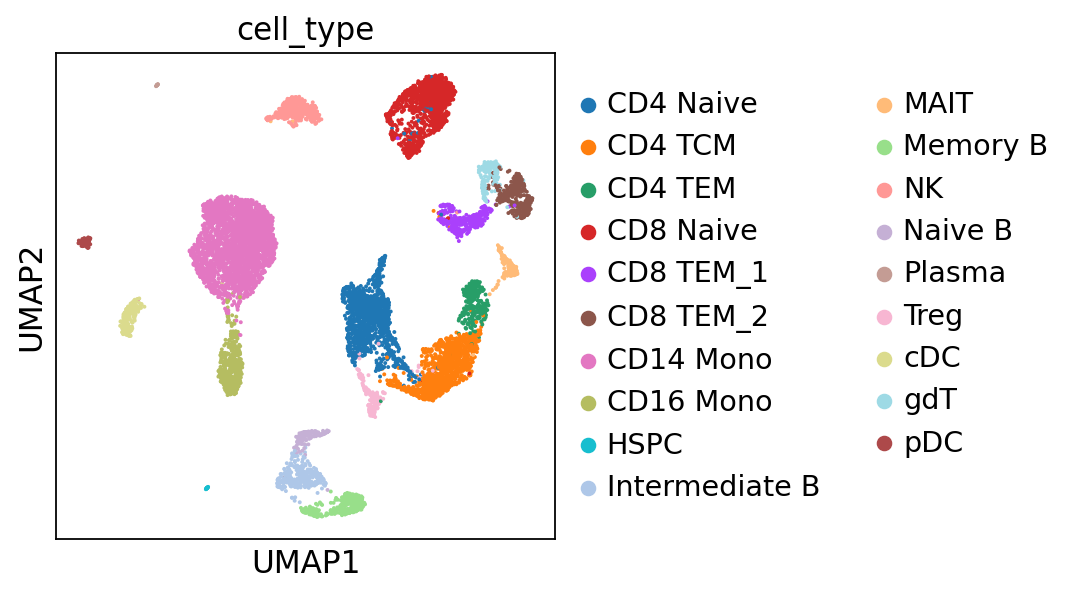

In [38]:
sc.pl.umap(rna, color=["cell_type"])